<a href="https://colab.research.google.com/github/hmierz/Employee-Retention-Analysis/blob/main/Retention_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q pandas matplotlib seaborn scipy statsmodels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

sns.set(rc={"figure.figsize": (7, 4)})
pd.set_option("display.float_format", lambda x: f"{x:.4f}")

In [3]:
# Load data
DATA_FILE = "hr_sample.csv"

df = pd.read_csv(DATA_FILE)

# Normalize common column-name variants just in case
rename_map = {
    "average_montly_hours": "average_monthly_hours",  # common misspelling in some copies
    "sales": "department"                              # some versions call department "sales"
}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

required_cols = [
    "satisfaction_level", "last_evaluation", "number_project", "average_monthly_hours",
    "time_spend_company", "Work_accident", "left", "promotion_last_5years", "department", "salary"
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.7800,0.9300,4,225,5,0,1,0,sales,2
1,0.7500,0.9900,5,221,5,0,1,0,product_mng,1
2,0.1900,0.9100,6,152,3,0,0,0,sales,1
3,0.6400,0.5100,3,257,3,1,0,0,IT,1
4,0.6600,0.6700,2,255,3,0,1,0,technical,1


,count,mean,std,min,25%,50%,75%,max
left,,,,,,,,
0,69.0000,0.6203,0.2346,0.0900,0.5000,0.6200,0.7900,1.0000
1,31.0000,0.4784,0.2560,0.0900,0.3600,0.4300,0.7400,0.9100


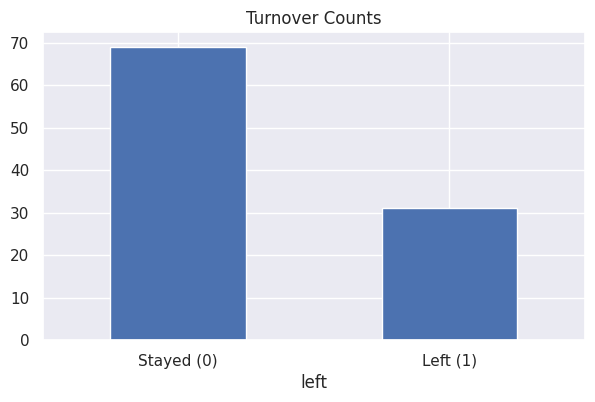

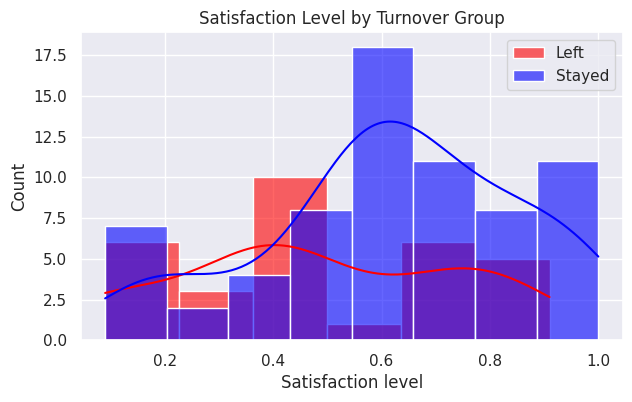

In [4]:
# Visuals and Descriptive Statistics
# Descriptive statistics by turnover
desc = df.groupby("left")["satisfaction_level"].describe()
display(desc)

# Bar chart: counts of left vs stayed
ax = df["left"].value_counts().sort_index().plot(kind="bar", title="Turnover Counts")
ax.set_xticklabels(["Stayed (0)", "Left (1)"], rotation=0)
plt.show()

# Histogram: satisfaction by group
sns.histplot(df[df["left"]==1]["satisfaction_level"], kde=True, label="Left", color="red", alpha=0.6)
sns.histplot(df[df["left"]==0]["satisfaction_level"], kde=True, label="Stayed", color="blue", alpha=0.6)
plt.legend()
plt.title("Satisfaction Level by Turnover Group")
plt.xlabel("Satisfaction level")
plt.show()

In [6]:
# Z-scores
df["satisfaction_z"] = stats.zscore(df["satisfaction_level"])
display(df[["satisfaction_level", "satisfaction_z"]].head())

print("Z mean:", round(df["satisfaction_z"].mean(), 4))
print("Z std:", round(df["satisfaction_z"].std(ddof=0), 4))

,satisfaction_level,satisfaction_z
0,0.7800,0.8220
1,0.7500,0.7010
2,0.1900,-1.5589
3,0.6400,0.2571
4,0.6600,0.3378


Z mean: -0.0
Z std: 1.0


In [7]:
# Hypothesis tests
# 1) T-test: average monthly hours by turnover
left_hours = df.loc[df["left"]==1, "average_monthly_hours"].dropna()
stay_hours = df.loc[df["left"]==0, "average_monthly_hours"].dropna()
t_stat, p_val = stats.ttest_ind(left_hours, stay_hours, equal_var=False)
print(f"T-test hours: t={t_stat:.3f}, p={p_val:.4g}")

T-test hours: t=1.685, p=0.09912


In [8]:
# 2) Mann-Whitney U: ordinal salary by turnover
# If salary is strings (low/medium/high), map to ordinal. If numeric, keep as-is.
if df["salary"].dtype == object:
    salary_map = {"low": 1, "medium": 2, "high": 3}
    df["salary_ord"] = df["salary"].str.lower().map(salary_map)
else:
    df["salary_ord"] = df["salary"]

left_sal = df.loc[df["left"]==1, "salary_ord"].dropna()
stay_sal = df.loc[df["left"]==0, "salary_ord"].dropna()
u_stat, p_val_u = stats.mannwhitneyu(left_sal, stay_sal, alternative="two-sided")
print(f"Mann-Whitney U (salary ordinal): U={u_stat:.3f}, p={p_val_u:.4g}")

Mann-Whitney U (salary ordinal): U=996.500, p=0.519


In [9]:
# 3) Chi-square: Work accident vs turnover
ct = pd.crosstab(df["Work_accident"], df["left"])
chi2, p_chi, dof, exp = stats.chi2_contingency(ct)
print("Contingency table:\n", ct)
print(f"Chi-square: chi2={chi2:.3f}, dof={dof}, p={p_chi:.4g}")

Contingency table:
 left            0   1
Work_accident        
0              54  28
1              15   3
Chi-square: chi2=1.370, dof=1, p=0.2418


In [10]:
# Correlation and Regression
# Spearman correlation: satisfaction vs left
rho, p_spear = stats.spearmanr(df["satisfaction_level"], df["left"])
print(f"Spearman(satisfaction vs left): rho={rho:.3f}, p={p_spear:.4g}")

Spearman(satisfaction vs left): rho=-0.256, p=0.01007


In [11]:
# Regression: last_evaluation -> satisfaction_level
X = sm.add_constant(df["last_evaluation"])
y = df["satisfaction_level"]
model = sm.OLS(y, X, missing="drop").fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     satisfaction_level   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     3.912
Date:                Wed, 01 Oct 2025   Prob (F-statistic):             0.0507
Time:                        19:45:41   Log-Likelihood:               -0.42195
No. Observations:                 100   AIC:                             4.844
Df Residuals:                      98   BIC:                             10.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3809      0.102     

In [12]:
# Summary
print("""
Key insights to verify after reviewing outputs:
- Satisfaction is lower among employees who left.
- Employees who left worked more average monthly hours.
- Salary and work accidents show associations with turnover.
- Last evaluation shows a small positive association with satisfaction.
""")


Key insights to verify after reviewing outputs:
- Satisfaction is lower among employees who left.
- Employees who left worked more average monthly hours.
- Salary and work accidents show associations with turnover.
- Last evaluation shows a small positive association with satisfaction.

